In [7]:
# made by Gibeom LEE, HI LAB
# Vpp finder와 기능은 같음. 다만, 일부분 피크를 발췌해서 정리해줌!

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [9]:
# 사용자 선택: 피크 탐지 모드
# "neg"  → 음의 피크만 (Abs. Peak Mag. 분석)
# "pos"  → 양의 피크만 (Abs. Peak Mag. 분석)
# "both" → 양/음 피크 모두 (Vpp 분석)
peak_mode = "neg"

# -------------------------------
# 폴더 경로
folder_path = r"G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\4. Data measurement\251108_진짜 마지막\0minimized_4ghk\volume"


# 사용자 설정값
prominence_ratio = 0.3   # 표준편차(std) * 비율로 prominence 기준 설정
min_prominence   = 0.1   # prominence 하한 
min_distance_sec = 0.05  # 인접 피크 최소 간격(초)
snr_threshold    = 2     # SNR 기준
min_relative_height = 0.03  # 전체 최대 진폭 대비 최소 비율
abs_min_height = 5       # 최소 피크 height

window_peaks = 5       # <<<< 연속 피크 개수

# 그래프 Y축
y_range = (None, None)
y_range = (-150, 10)

# csv파일 저장
save_summary_csv = False  # False 로 하면 CSV 저장 안 함
#save_summary_csv = True

Volume_15uL_Peak value: 20.63 V
Volume_15uL_Peak number: 31개
Volume_15uL_표준편차: 12.56
Volume_15uL_주파수: 4.64 Hz
👉 Volume_15uL 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 166.58
   - 발췌 평균 Peak value: 30.42 V (표준편차: 15.99 V)
   - 발췌 평균 주파수: 3.41 Hz


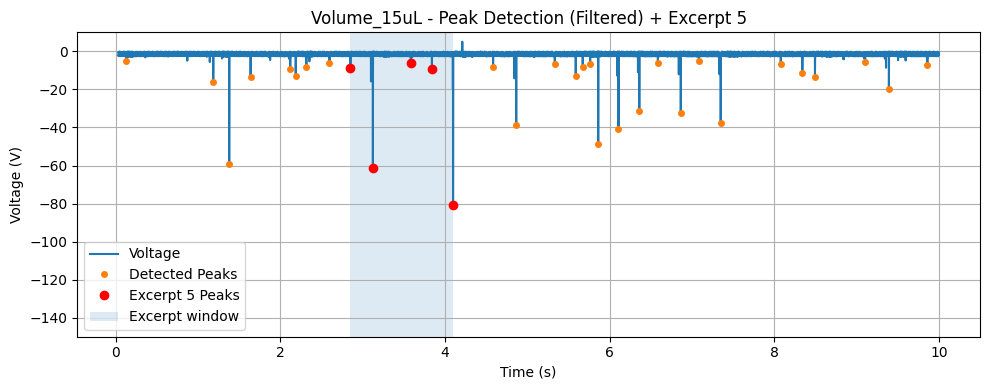

Volume_29uL_Peak value: 71.62 V
Volume_29uL_Peak number: 61개
Volume_29uL_표준편차: 10.84
Volume_29uL_주파수: 6.41 Hz
👉 Volume_29uL 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 399.27
   - 발췌 평균 Peak value: 79.25 V (표준편차: 4.95 V)
   - 발췌 평균 주파수: 6.23 Hz


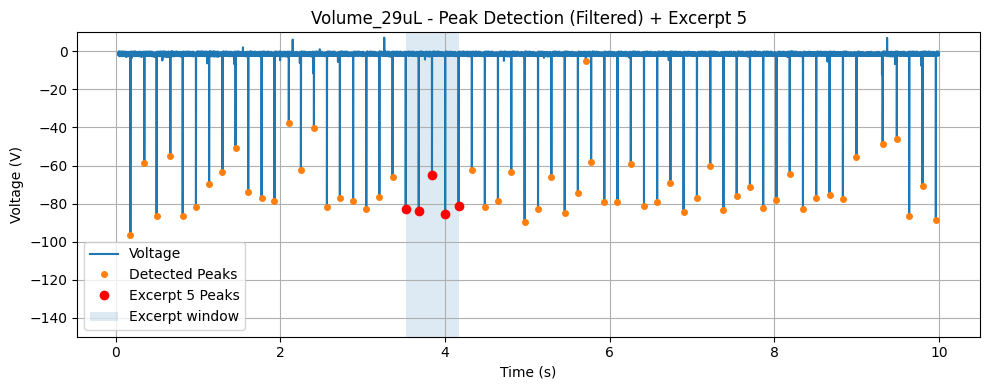

Volume_54uL_Peak value: 104.47 V
Volume_54uL_Peak number: 49개
Volume_54uL_표준편차: 11.25
Volume_54uL_주파수: 5.06 Hz
👉 Volume_54uL 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 583.73
   - 발췌 평균 Peak value: 116.06 V (표준편차: 4.07 V)
   - 발췌 평균 주파수: 5.11 Hz


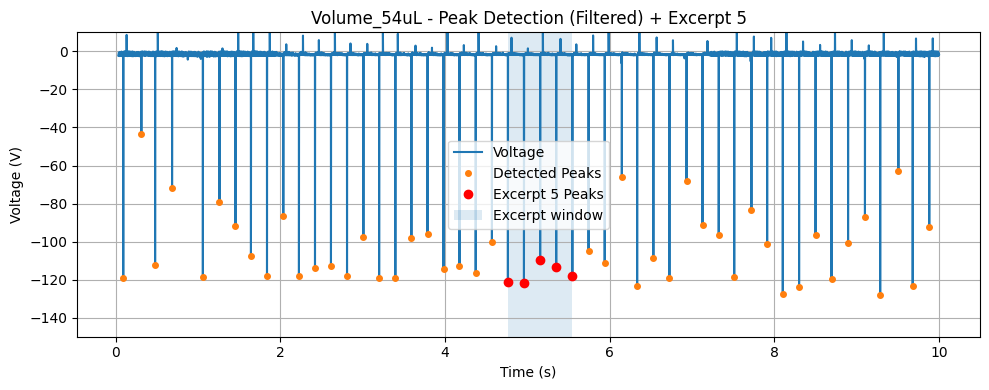

Volume_67uL_Peak value: 125.69 V
Volume_67uL_Peak number: 39개
Volume_67uL_표준편차: 12.38
Volume_67uL_주파수: 4.17 Hz
👉 Volume_67uL 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 688.69
   - 발췌 평균 Peak value: 137.47 V (표준편차: 0.74 V)
   - 발췌 평균 주파수: 3.79 Hz


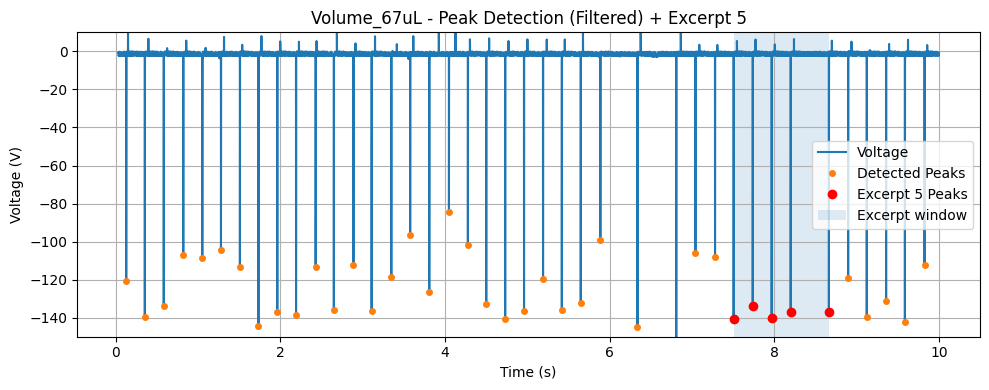


🎯 모든 파일 발췌 결과 요약 (연속 5개 피크 기준)
Volume_15uL.csv | Peak value: 30.42 V | 표준편차: 15.99 V | 주파수: 3.41 Hz
Volume_29uL.csv | Peak value: 79.25 V | 표준편차: 4.95 V | 주파수: 6.23 Hz
Volume_54uL.csv | Peak value: 116.06 V | 표준편차: 4.07 V | 주파수: 5.11 Hz
Volume_67uL.csv | Peak value: 137.47 V | 표준편차: 0.74 V | 주파수: 3.79 Hz

📊 발췌 구간 전체 평균 Peak value: 90.80 V
📉 발췌 구간 표준편차(Peak value): 46.89 V
🎵 발췌 구간 평균 주파수: 4.63 Hz


In [10]:
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
all_analysis_values = [] 
file_std_values = []
all_freq_values = []

# (선택) 발췌 요약 모음 저장용
excerpt_mean_analysis_list = []
excerpt_std_analysis_list  = []
excerpt_mean_freq_list = []

# 분석 단위 이름 설정
if peak_mode == "both":
    analysis_unit = "Vpp"
else:
    analysis_unit = "Peak value" # 이름 변경: 구간 평균이 아닌 피크 평균임을 명시


for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # 데이터 로드
        df = pd.read_csv(file_path, skiprows =30)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values

        # 샘플링 속도
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # ===============================
        # 피크 검출 (양/음/양+음 선택 가능)
        # ===============================
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)

        if peak_mode == "neg":
            raw_peaks, _ = find_peaks(-voltage, prominence=prom, distance=distance)

        elif peak_mode == "pos":
            raw_peaks, _ = find_peaks(voltage, prominence=prom, distance=distance)

        elif peak_mode == "both":
            raw_peaks_pos, _ = find_peaks(voltage, prominence=prom, distance=distance)
            raw_peaks_neg, _ = find_peaks(-voltage, prominence=prom, distance=distance)
            raw_peaks = np.sort(np.concatenate([raw_peaks_pos, raw_peaks_neg]))

        else:
            raise ValueError("peak_mode는 'neg', 'pos', 'both' 중 하나여야 합니다.")

        # 피크 필터링(SNR/상대높이)
        max_amplitude = np.max(np.abs(voltage)) if len(voltage) > 0 else 0.0
        
        final_peaks = []
        for i in raw_peaks:
            left  = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = abs(voltage[i])

            if (signal > max_amplitude * min_relative_height and 
                (signal / local_noise) > snr_threshold and
                signal > abs_min_height):
                final_peaks.append(i)
        final_peaks = np.array(final_peaks, dtype=int)
        

        final_peaks = np.array(final_peaks, dtype=int)
        peak_times  = time[final_peaks]

        # 전체 분석 값 계산 (모드에 따라 Vpp 또는 Abs. Peak Mag.)
        analysis_list = []
        for i in range(len(final_peaks) - 1):
            s = final_peaks[i]
            e = final_peaks[i + 1]
            
            if peak_mode == "both":
                # 'both' 모드는 Vpp 계산: MAX - MIN (양/음 모두 고려)
                analysis_val = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
            else:
                # 'neg'/'pos' 모드는 피크 i와 피크 i+1의 절댓값 평균으로 계산 (수정된 로직)
                # 이 값이 구간의 평균 진폭을 가장 잘 대표함
                mag_i = np.abs(voltage[final_peaks[i]])
                mag_i_plus_1 = np.abs(voltage[final_peaks[i+1]])
                analysis_val = (mag_i + mag_i_plus_1) / 2
                
            analysis_list.append(analysis_val)
            
        mean_analysis = np.mean(analysis_list) if analysis_list else 0.0
        std_analysis  = np.std(analysis_list, ddof=1) if len(analysis_list) > 1 else 0.0

        # 전체 평균 주파수
        if len(peak_times) < 2:
            mean_freq = 0.0
        else:
            periods = np.diff(peak_times)
            mean_freq = float(np.mean(1.0 / periods))

        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_{analysis_unit}: {mean_analysis:.2f} V")
        print(f"{base_name}_Peak number: {len(analysis_list):.0f}개")
        print(f"{base_name}_표준편차: {std_analysis:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        # 저장
        all_analysis_values.append(mean_analysis)
        file_std_values.append(std_analysis)
        all_freq_values.append(mean_freq)

        # ====== [신규 기능] 연속된 5개 피크 중 합이 최대인 집합 발췌 ======
        if len(final_peaks) >= window_peaks:
            # 피크 크기 정의: 모든 모드에서 피크 크기의 절댓값으로 통일하여 최대 합 구간을 찾음
            peak_mags = np.abs(voltage[final_peaks]).astype(float)

            # 누적합을 이용해 길이 window_peaks의 구간합 계산
            csum = np.cumsum(peak_mags)
            sums = csum[window_peaks - 1:] - np.concatenate(([0.0], csum[:-window_peaks]))
            best_start_idx = int(np.argmax(sums))
            best_end_idx   = best_start_idx + window_peaks

            # 발췌된 5개 피크의 "원본 인덱스"
            excerpt_peak_idx = final_peaks[best_start_idx:best_end_idx]
            excerpt_peak_times = time[excerpt_peak_idx]
            excerpt_peak_mags  = peak_mags[best_start_idx:best_end_idx]


            # 발췌 구간의 분석 값 계산 (모드에 따라 Vpp 또는 Abs. Peak Mag.)
            excerpt_analysis = []
            for j in range(window_peaks - 1):
                i = best_start_idx + j # 현재 피크 인덱스 (final_peaks 기준)
                
                if peak_mode == "both":
                    # 'both' 모드는 Vpp 계산
                    s = excerpt_peak_idx[j]
                    e = excerpt_peak_idx[j + 1]
                    analysis_seg = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
                else:
                    # 'neg'/'pos' 모드는 피크 i와 피크 i+1의 절댓값 평균으로 계산 (수정된 로직)
                    mag_i = np.abs(voltage[final_peaks[i]])
                    mag_i_plus_1 = np.abs(voltage[final_peaks[i+1]])
                    analysis_seg = (mag_i + mag_i_plus_1) / 2
                    
                excerpt_analysis.append(analysis_seg)
                
            excerpt_mean_analysis = float(np.mean(excerpt_analysis)) if excerpt_analysis else 0.0
            excerpt_std_analysis  = float(np.std(excerpt_analysis, ddof=1)) if len(excerpt_analysis) > 1 else 0.0

            # 발췌 구간의 평균 주파수(5개 피크 → 4개 구간)
            if len(excerpt_peak_times) >= 2:
                excerpt_periods = np.diff(excerpt_peak_times)
                excerpt_mean_freq = float(np.mean(1.0 / excerpt_periods))
            else:
                excerpt_mean_freq = 0.0

            # 콘솔 출력
            print(f"👉 {base_name} 발췌(연속 {window_peaks}개) 정보")
            print(f"   - 합계(피크 크기 합): {np.sum(excerpt_peak_mags):.2f}")
            print(f"   - 발췌 평균 {analysis_unit}: {excerpt_mean_analysis:.2f} V (표준편차: {excerpt_std_analysis:.2f} V)")
            print(f"   - 발췌 평균 주파수: {excerpt_mean_freq:.2f} Hz")

            # (선택) 전체 요약용 리스트에 저장
            excerpt_mean_analysis_list.append(excerpt_mean_analysis)
            excerpt_std_analysis_list.append(excerpt_std_analysis)
            excerpt_mean_freq_list.append(excerpt_mean_freq)
           

            # ====== 그래프: 전체 + 발췌구간 강조 ======
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage')
            # 전체 검출 피크(주황색)
            if len(final_peaks) > 0:
                plt.plot(time[final_peaks], voltage[final_peaks], 'o', ms=4, label='Detected Peaks')
            # 발췌된 5개 피크(빨간 점)
            plt.plot(time[excerpt_peak_idx], voltage[excerpt_peak_idx], 'ro', ms=6, label=f'Excerpt {window_peaks} Peaks')
            # 발췌 구간 배경 밴드
            t0, t1 = time[excerpt_peak_idx[0]], time[excerpt_peak_idx[-1]]
            plt.axvspan(t0, t1, alpha=0.15, label='Excerpt window')

            plt.title(f"{base_name} - Peak Detection (Filtered) + Excerpt {window_peaks}")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            # 기존 그래프(발췌 불가 시 기본만 표시)
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage', color='gray')
            if len(final_peaks) > 0:
                plt.plot(time[final_peaks], voltage[final_peaks], 'ro', ms=4, label='Detected Peaks')
            plt.title(f"{base_name} - Peak Detection (Filtered) (not enough peaks for excerpt)")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")

# -------------------------------
# 전체 요약 출력
print("\n==============================")
print(f"🎯 모든 파일 발췌 결과 요약 (연속 {window_peaks}개 피크 기준)")
for i in range(len(excerpt_mean_analysis_list)):
    print(f"{csv_files[i]} | {analysis_unit}: {excerpt_mean_analysis_list[i]:.2f} V | "
          f"표준편차: {excerpt_std_analysis_list[i]:.2f} V | "
          f"주파수: {excerpt_mean_freq_list[i]:.2f} Hz")

# 전체 평균 요약
if excerpt_mean_analysis_list:
    avg_analysis = np.mean(excerpt_mean_analysis_list)
    avg_std = np.std(excerpt_mean_analysis_list, ddof=1) if len(excerpt_mean_analysis_list) > 1 else 0.0
    avg_freq = np.mean(excerpt_mean_freq_list)

    print("\n==============================")
    print(f"📊 발췌 구간 전체 평균 {analysis_unit}: {avg_analysis:.2f} V")
    print(f"📉 발췌 구간 표준편차({analysis_unit}): {avg_std:.2f} V")
    print(f"🎵 발췌 구간 평균 주파수: {avg_freq:.2f} Hz")

    # ===============================
    # CSV 저장 여부 선택
    # ===============================
    

    if save_summary_csv:
        # CSV 컬럼 이름도 수정된 분석 단위에 맞게 변경
        summary_df = pd.DataFrame({
            "File": csv_files[:len(excerpt_mean_analysis_list)],
            f"{analysis_unit.replace('.', '').replace(' ', '_')}": excerpt_mean_analysis_list,
            f"Std": excerpt_std_analysis_list,
            "Freq": excerpt_mean_freq_list
        })

        # 평균값 한 줄 추가
        summary_df.loc["Average"] = ["ALL_AVG", avg_analysis, avg_std, avg_freq]

        output_path = os.path.join(folder_path, "00summary_excerpt_results.csv")
        summary_df.to_csv(output_path, index=False, encoding="utf-8-sig")
        print(f"✅ 요약 결과 CSV 저장 완료: {output_path}")

else:
    print("📭 데이터를 계산할 수 없습니다.")